# Проектная работа: Определение стоимости автомобилей

## Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля.

В нашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

**Целью** данной работы является построение модели, которая умеет определять рыночную стоимость автомобиля. 

Критерии, которые важны заказчику:

- качество предсказания;
- время обучения модели;
- время предсказания модели.

В связи с этим перед нами стоят следующие **задачи**:

- подготовить данные;
- обучить разные модели;
- проанализировать время обучения, время предсказания и качество моделей;
- на основе критериев от заказчика выбрать лучшую модель.

**Примечания**:
- для оценки качества моделей будем применять метрику RMSE;
- значение метрики RMSE должно быть меньше 2500.

**Описание данных**:
- **Признаки**:
    - `DateCrawled` — дата скачивания анкеты из базы;
    - `VehicleType` — тип автомобильного кузова;
    - `RegistrationYear` — год регистрации автомобиля;
    - `Gearbox` — тип коробки передач;
    - `Power` — мощность (л. с.);
    - `Model` — модель автомобиля;
    - `Kilometer` — пробег (км);
    - `RegistrationMonth` — месяц регистрации автомобиля;
    - `FuelType` — тип топлива;
    - `Brand` — марка автомобиля;
    - `Repaired` — была машина в ремонте или нет;
    - `DateCreated` — дата создания анкеты;
    - `NumberOfPictures` — количество фотографий автомобиля;
    - `PostalCode` — почтовый индекс владельца анкеты (пользователя);
    - `LastSeen` — дата последней активности пользователя;
- **Целевой признак**:
    - `Price` - цена (евро). 

**План проектной работы**:
1. Загрузка и изучение данных;
2. Предобработка данных;
3. Подготовка выборки для обучения моделей;
4. Обучение моделей, анализ времени обучения и предсказания и качества моделей; 
5. Выбор лучшей модели и проверка ее качества на тестовой выборке;
6. Выводы.

### Шаг 1. Загрузка и изучение данных

In [1]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import lightgbm as lgb
from scipy import stats as st
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor



%matplotlib inline 

In [2]:
df = pd.read_csv("autos.csv")
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
df.shape

(354369, 16)

Датасет содержит более 350 тыс. строк и 16 столбцов.

In [4]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [5]:
df.dtypes

DateCrawled          object
Price                 int64
VehicleType          object
RegistrationYear      int64
Gearbox              object
Power                 int64
Model                object
Kilometer             int64
RegistrationMonth     int64
FuelType             object
Brand                object
Repaired             object
DateCreated          object
NumberOfPictures      int64
PostalCode            int64
LastSeen             object
dtype: object

В столбцах датасета содержатся только два типа данных - `object` и `int64`. В тех столбцах, где представлены даты, можно было бы поменять тип данных с `object` на `datetime`, однако эти признаки могут быть непригодны для обучения модели.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

В датасете присутствуют признаки с пропущенными значениями.

In [7]:
df.duplicated().sum()

4

Набор данных содержит 4 объекта, которые дублируют друг друга.

### Выводы
---
Таким образом, перед нами задача регрессии. Целевой признак - стоимость автомобиля (`price`), в качестве признаков предлагаются 16 столбцов, которые содержатся в датасете. Однако не все пригодны для построения моделей. Группа признаков (`DateCrawled`, `DateCreated`, `NumberOfPictures`, `PostalCode`, `LastSeen`) вовсе не характеризуют автомобили в датасете, а признаки `RegistrationMonth` и `RegistrationYear` имеют схожую природу, т.е. сообщают нам дату регистрации автомобиля, однако последний признак носит более ценную информацию об автомобиле. Поэтому лишние признаки исключим из датасета, и тем самым необходимость менять тип данных пропадает. Также посмотрим на дублирующие объекты и избавимся от них, если действительно произошло многоразовое копирование одного и того же объекта.

### Шаг 2. Предобработка данных

##### Удаление дубликатов

In [8]:
df[df.duplicated()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


In [9]:
df[df["DateCrawled"] == "2016-03-08 18:42:48"]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57


In [10]:
df[df["DateCrawled"] == "2016-03-28 00:56:10"]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21


In [11]:
df[df["DateCrawled"] == "2016-04-03 09:01:15"]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54


In [12]:
df[df["DateCrawled"] == "2016-03-18 18:46:15"]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


Действительно в датасете 4 объекта дублировались, в чем мы убедились после того, как нашли их. Теперь может удалить их. 

In [13]:
df = df.drop_duplicates()

In [14]:
df.duplicated().sum()

0

##### Удаление из датасета лишних признаков

In [15]:
df = df.drop(["DateCrawled", "DateCreated", "NumberOfPictures", 
              "PostalCode", "LastSeen", "RegistrationMonth"], axis = 1)

In [16]:
df.shape

(354365, 10)

Мы исключили 6 признаков, которые непригодны для построения моделей.

##### Обработка пропущенных значений

In [17]:
df.isna().sum().sort_values(ascending = False)

Repaired            71154
VehicleType         37490
FuelType            32895
Gearbox             19833
Model               19705
Price                   0
RegistrationYear        0
Power                   0
Kilometer               0
Brand                   0
dtype: int64

Как видно, пропущенные значения присутствуют только в признаках с категориальными данными.

In [18]:
for col in ["Repaired", "VehicleType", "FuelType", "Gearbox", "Model"]:
    print(f"{col} unique values:", df[col].unique(), sep = "\n")
    print()

Repaired unique values:
[nan 'yes' 'no']

VehicleType unique values:
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']

FuelType unique values:
['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']

Gearbox unique values:
['manual' 'auto' nan]

Model unique values:
['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace'

Так как некоторые признаки взаимосвязаны в датасете, то нам необходимо заполнять пропуски таким образом, чтобы не нарушить общую логику в данных. Например, вряд ли электрокар может быть выпущен в XX веке, или некоторые модели автомобилей выпускаются только с определенным кузовом. Поэтому алгоритм при заполнении должен быть достаточно сложным, который учитывает все эти особенности. 

Однако в большинстве признаков, которые содержат пропуски, есть значение `other`, и это должно нам помочь. Если мы заполним пропущенные значения в признаках `VehicleType`, `FuelType` и `Model` значением `other`, то мы не нарушим общую логику, заложенную в датасет. 

В признаке `Repaired` могут быть только два значения. Была ли машина в ремонте или нет не зависит от остальных признаков, поэтому мы можем заполнить случаным образом.

При заполнении `Gearbox` будем придерживаться консервативного подхода. Автоматическая коробка передач стала популярной в новейшее время, и, как правило, автомобили с механической коробкой передач встречаются чаще. Поэтому в объектах с пропущенными значениями укажем механическую коробку передач.

In [19]:
random.seed(12345)
repaired_before = df["Repaired"]
df["Repaired"] = df["Repaired"].fillna(random.choice(df["Repaired"].unique()[1:]))
repaired_after = df["Repaired"]

In [20]:
df["Gearbox"] = df["Gearbox"].fillna(df["Gearbox"].value_counts(normalize = True).idxmax())

In [21]:
df[["Repaired", "Gearbox"]].isna().sum()

Repaired    0
Gearbox     0
dtype: int64

Пропущенных значений больше нет.

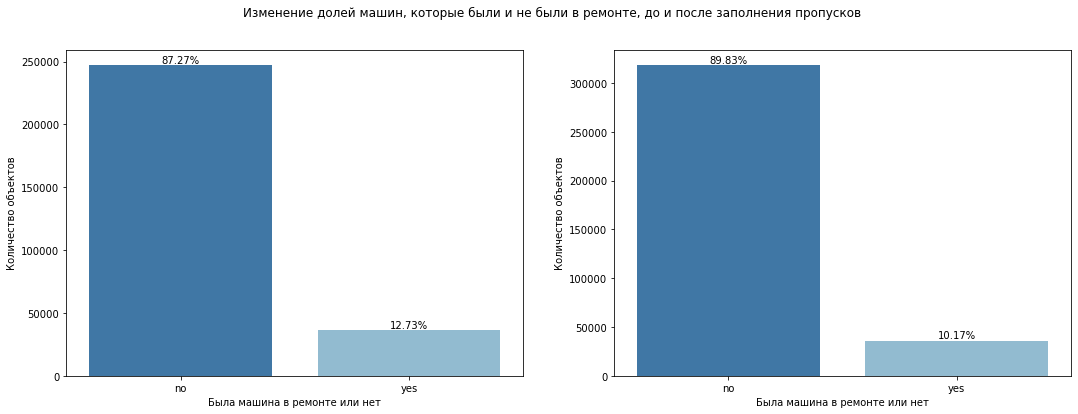

In [22]:
fig = plt.figure(figsize = (18, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

sns.countplot(x = repaired_before, order = repaired_before.value_counts(ascending = False).index,
                    palette = sns.color_palette("RdBu_r"), ax = ax1)

ax1.bar_label(container = ax1.containers[0],
             labels = ["{:,.2%}".format(i) for i in repaired_before.value_counts(ascending = False, 
                                                                                   normalize = True).values])
ax1.set(xlabel = "Была машина в ремонте или нет", ylabel = "Количество объектов")


sns.countplot(x = repaired_after, order = repaired_after.value_counts(ascending = False).index,
                    palette = sns.color_palette("RdBu_r"), ax = ax2)

ax2.bar_label(container = ax2.containers[0],
             labels = ["{:,.2%}".format(i) for i in repaired_after.value_counts(ascending = False, 
                                                                                   normalize = True).values])
ax2.set(xlabel = "Была машина в ремонте или нет", ylabel = "Количество объектов")

fig.suptitle("Изменение долей машин, которые были и не были в ремонте, до и после заполнения пропусков")
plt.show()

На примере `Repaired` видим, что баланс классов существенно не изменился. Также результат заполнения пропусков на `other` в остальных признаках посмотрим на примере `VehicleType`. Ниже диаграмма до заполнения пропусков.

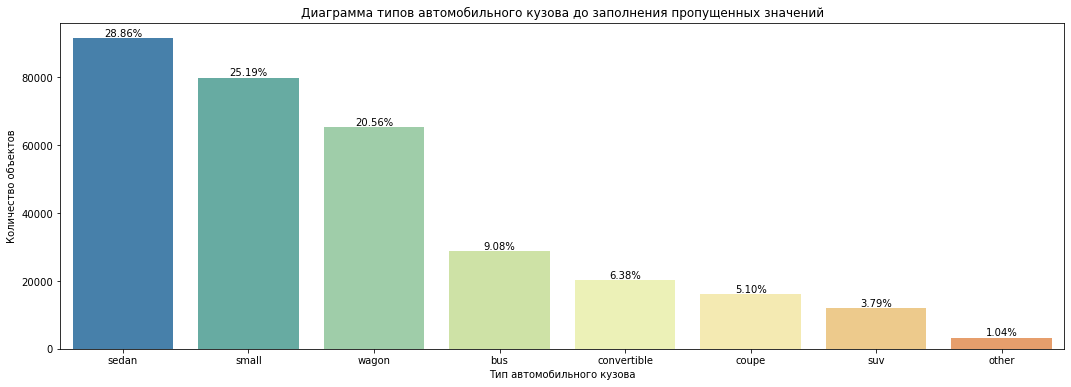

In [23]:
fig, ax = plt.subplots(figsize = (18, 6))
ax = sns.countplot(data = df, x = "VehicleType", 
                   order = df["VehicleType"].value_counts(ascending = False).index,
                  palette = sns.color_palette("Spectral_r", 10))
ax.bar_label(container = ax.containers[0],
             labels = ["{:,.2%}".format(i) for i in df["VehicleType"].value_counts(ascending = False, 
                                                                                   normalize = True).values])
plt.title("Диаграмма типов автомобильного кузова до заполнения пропущенных значений")
plt.xlabel("Тип автомобильного кузова")
plt.ylabel("Количество объектов")
plt.show()

In [24]:
df["VehicleType"] = df["VehicleType"].fillna("other")
df["FuelType"] = df["FuelType"].fillna("other")
df["Model"] = df["Model"].fillna("other")

df[["VehicleType", "FuelType", "Model"]].isna().sum()

VehicleType    0
FuelType       0
Model          0
dtype: int64

Пропущенных значений в признаках `VehicleType`, `FuelType` и `Model` больше нет, посмотрим, как поменялся баланс классов в `VehicleType`. 

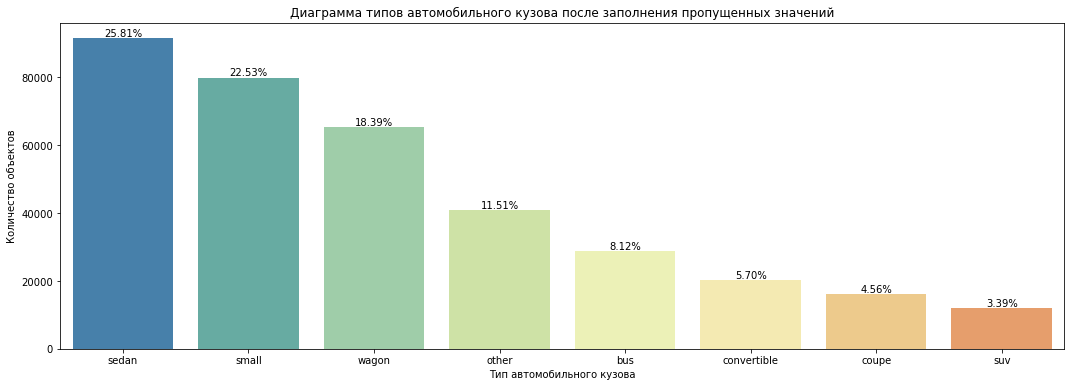

In [25]:
fig, ax = plt.subplots(figsize = (18, 6))
ax = sns.countplot(data = df, x = "VehicleType", 
                   order = df["VehicleType"].value_counts(ascending = False).index,
                  palette = sns.color_palette("Spectral_r", 10))
ax.bar_label(container = ax.containers[0],
             labels = ["{:,.2%}".format(i) for i in df["VehicleType"].value_counts(ascending = False, 
                                                                                   normalize = True).values])
plt.title("Диаграмма типов автомобильного кузова после заполнения пропущенных значений")
plt.xlabel("Тип автомобильного кузова")
plt.ylabel("Количество объектов")
plt.show()

Доля `other` заметно выросла.

##### Проверка адекватности значений в признаках

Аномальные значения присутствуют в `Price`, `RegistrationYear` и `Power`, обнаружить их поможет диаграмма размаха. Построим такую диаграмму для каждого признака и разберем по отдельности.

In [26]:
df[["Price", "RegistrationYear", "Power"]].describe().T

,count,mean,std,min,25%,50%,75%,max
Price,354365.0,4416.679830,4514.176349,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354365.0,2004.234481,90.228466,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354365.0,110.093816,189.851330,0.0,69.0,105.0,143.0,20000.0


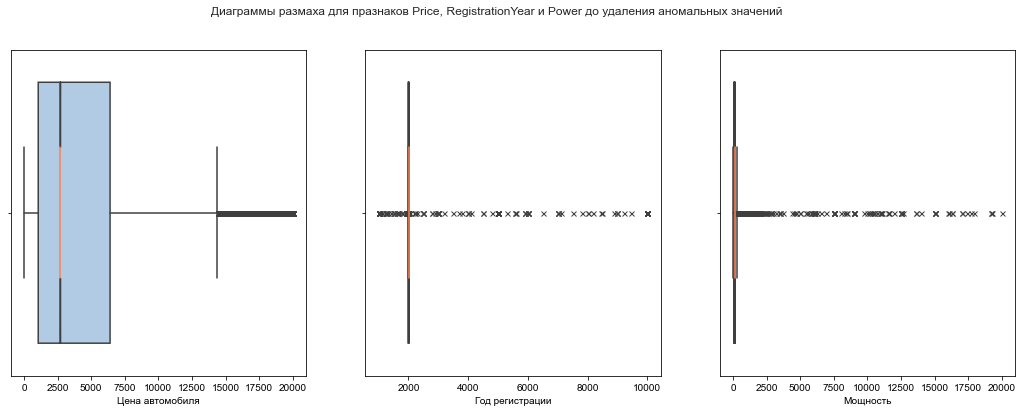

In [27]:
fig = plt.figure(figsize = (18, 6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
sns.set_style("dark")

sns.boxplot(data = df, x = "Price", notch = True, flierprops = {"marker" : "x"},
            boxprops = {"facecolor" : (.4, .6, .8, .5)}, medianprops = {"color" : "coral"}, ax = ax1)
ax1.set(xlabel = "Цена автомобиля")

sns.boxplot(data = df, x = "RegistrationYear", notch = True, flierprops = {"marker" : "x"},
            boxprops = {"facecolor" : (.4, .6, .8, .5)}, medianprops = {"color" : "coral"}, ax = ax2)
ax2.set(xlabel = "Год регистрации")

sns.boxplot(data = df, x = "Power", notch = True, flierprops = {"marker" : "x"},
            boxprops = {"facecolor" : (.4, .6, .8, .5)}, medianprops = {"color" : "coral"}, ax = ax3)
ax3.set(xlabel = "Мощность")

plt.suptitle("Диаграммы размаха для празнаков Price, RegistrationYear и Power до удаления аномальных значений")
plt.show()

Как видно на диаграммах размаха, большое количество аномальных значений присутствует в признаках `RegistrationYear` и `Power`, в признакое `Price` тоже есть аномальные значения. Посмотрим, какую долю занимают аномальные значения в общем наборе данных. Для этого напишем функцию, которая посчитает наблюдаемые минимумы и максимумы диаграммы размаха. 

In [28]:
def caps_calculation(data):
    upper_quartile = np.percentile(data, 75)
    lower_quartile = np.percentile(data, 25)
    
    iqr = upper_quartile - lower_quartile
    
    lower_cap = data[data >= lower_quartile - 1.5 * iqr].min()
    upper_cap = data[data <= upper_quartile + 1.5 * iqr].max()
    
    return (lower_cap, upper_cap)    

In [29]:
print("Диапозон наблюдаемых минимума и максимума для признака Price:", caps_calculation(df["Price"]))

Диапозон наблюдаемых минимума и максимума для признака Price: (0, 14400)


In [30]:
print("Диапозон наблюдаемых минимума и максимума для признака RegistrationYear:", 
      caps_calculation(df["RegistrationYear"]))

Диапозон наблюдаемых минимума и максимума для признака RegistrationYear: (1986, 2019)


In [31]:
print("Диапозон наблюдаемых минимума и максимума для признака Power:", caps_calculation(df["Power"]))

Диапозон наблюдаемых минимума и максимума для признака Power: (0, 254)


В результате рассчета наблюдаемых минимумов и максимумов диаграмм размаха мы видим, что для признаков Price и Power минимумы равняются 0. Логика подсказывает, что такого быть не должно. Значит, посмотрим, какую долю занимают в данных аномальные значения, включая и исключая 0. 

Стоит также отметить, что верхняя граница даты скачивания анкеты из базы - 2016 год, следовательно, верхняя граница года регистрации автомобиля должна равняться 2016 году. Здесь мы отдельно посмотрим, какую долю занимают данные от 2017 до 2019 годов. 

In [32]:
print("Доля аномальных значений в признаке Price:", 
      "{:,.2%}".format(1 - len(df.query("0 <= Price <= 14400")) / len(df)))

print("Доля аномальных значений в признаке Price, включая значение 0:", 
      "{:,.2%}".format(1 - len(df.query("1 <= Price <= 14400")) / len(df)))

Доля аномальных значений в признаке Price: 5.36%
Доля аномальных значений в признаке Price, включая значение 0: 8.40%


In [33]:
print("Доля аномальных значений в признаке RegistrationYear:", 
      "{:,.2%}".format(1 - len(df.query("1986 <= RegistrationYear <= 2019")) / len(df)))
print("Доля аномальных значений в признаке RegistrationYear с 2017 по 2019 гг.:", 
      "{:,.2%}".format(len(df.query("2017 <= RegistrationYear <= 2019")) / len(df)))

Доля аномальных значений в признаке RegistrationYear: 1.78%
Доля аномальных значений в признаке RegistrationYear с 2017 по 2019 гг.: 4.07%


In [34]:
print("Доля аномальных значений в признаке Power:", 
      "{:,.2%}".format(1 - len(df.query("0 <= Power <= 254")) / len(df)))

print("Доля аномальных значений в признаке Power, включая значение 0:", 
      "{:,.2%}".format(1 - len(df.query("1 <= Power <= 254")) / len(df)))

Доля аномальных значений в признаке Power: 2.07%
Доля аномальных значений в признаке Power, включая значение 0: 13.42%


Таким образом, в признаке Price доля аномальных значений составляет чуть больше 5%, а нулевые значения составляют примерно 3% от общего объема данных. А в признаках RegistrationYear и Power наблюдаются примерно по 2% аномальных значений. Однако доля нулевых значений в Power более 11%. Тем не менее, и в Price, и в Power не должны быть нулевые значения, а если мы удалим, то протеряем существенную долю исходных данных. Сгруппируем данные по `Brand`, `Model` и `RegistrationYear` и заменим нулевые значения `Price` и `Power` медианами.

In [35]:
df["Price"] = df.groupby(["Brand", "Model", "RegistrationYear"])["Price"].apply(lambda x: x.replace(0, x.median()))
df["Power"] = df.groupby(["Brand", "Model", "RegistrationYear"])["Power"].apply(lambda x: x.replace(0, x.median()))

In [36]:
df["RegistrationYear"] = df.groupby(["Brand", 
                                     "Model"])["RegistrationYear"].apply(lambda x: x.replace(2017, x.median()))
df["RegistrationYear"] = df.groupby(["Brand", 
                                     "Model"])["RegistrationYear"].apply(lambda x: x.replace(2018, x.median()))
df["RegistrationYear"] = df.groupby(["Brand", 
                                     "Model"])["RegistrationYear"].apply(lambda x: x.replace(2019, x.median()))

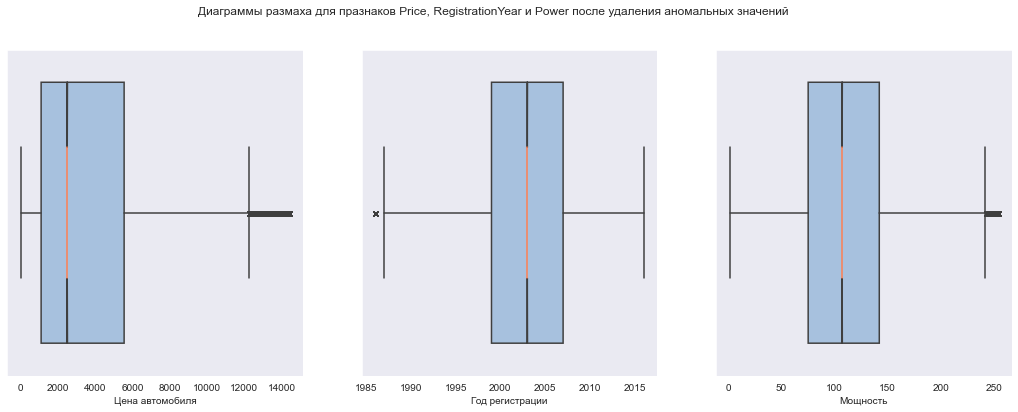

In [37]:
fig = plt.figure(figsize = (18, 6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
sns.set_style("dark")

sns.boxplot(data = df.query("1 <= Price <= 14400"), x = "Price", notch = True, flierprops = {"marker" : "x"},
            boxprops = {"facecolor" : (.4, .6, .8, .5)}, medianprops = {"color" : "coral"}, ax = ax1)
ax1.set(xlabel = "Цена автомобиля")

sns.boxplot(data = df.query("1986 <= RegistrationYear <= 2016"), x = "RegistrationYear", notch = True, 
            flierprops = {"marker" : "x"}, boxprops = {"facecolor" : (.4, .6, .8, .5)}, 
            medianprops = {"color" : "coral"}, ax = ax2)
ax2.set(xlabel = "Год регистрации")

sns.boxplot(data = df.query("1 <= Power <= 254"), x = "Power", notch = True, flierprops = {"marker" : "x"}, 
            boxprops = {"facecolor" : (.4, .6, .8, .5)}, medianprops = {"color" : "coral"}, ax = ax3)
ax3.set(xlabel = "Мощность")

plt.suptitle("Диаграммы размаха для празнаков Price, RegistrationYear и Power после удаления аномальных значений")
plt.show()

In [410]:
df = df.query("(1 <= Price <= 14400) & (1986 <= RegistrationYear <= 2016) & \
              (1 <= Power <= 254)").reset_index(drop = True)

In [411]:
print("Объем данных, который был исключен из датасета в качестве аномальных значений:", 
      "{:,.2%}".format(1 - len(df) / 354365))

Объем данных, который был исключен из датасета в качестве аномальных значений: 9.05%


Таким образом, из датасета были исключены чуть больше 9% данных в качестве аномальных значений.

### Шаг 3. Подготовка выборки для обучения моделей

В нашем датасете есть много категориальных признаков. Для обучения моделей необходимо их закодировать. Выбор метода кодирования зависит от того, важен ли в этом признаке порядок. В случае, если порядок не важен, то есть мы не можем сказать, что какой-то класс в данном категориальном признаке лучше, чем другой, то мы воспользуемся прямым кодированием (`one-hot encoding`), в противном случае нужно будет применять порядкое кодирование (`ordinal encoding`).

Вместе с тем надо помнить, что под некоторые виды моделей подходит определенная кодировка. Так, для древовидных моделей будем применять порядковое кодирование.

##### Исходные данные

Также стоит стандартизировать признаки `RegistrationYear`, `Power` и `Kilometer`, потому что у них разные масштабы, иначе модель может посчитать, что один из этих признаков важнее, чем другой.

Для стандартизации указанных признаков разобьем данные на обучающую и тестовую выборки. Валидационную выборку выделять нет необходимости, потому что в процессе обучения будем применять кросс-валидацию. На обучающую выборку отведем 80% от общего набора данных, а остальные 20% - на тестирование модели. В кросс-валидации число блоков традиционно будет равняться 5, то есть на каждой итерации из 80% от общего набора данных 16% будут выделены для валидации.

In [412]:
features = df.drop("Price", axis = 1)
target = df["Price"]

print("Размерность набора данных с признаками:", features.shape)
print("Размерность набора данных с таргетом:", target.shape)

Размерность набора данных с признаками: (322282, 9)
Размерность набора данных с таргетом: (322282,)


In [413]:
# разделим данные на обучающую и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(features, 
                target, test_size = 0.2, random_state = 1234)

# здесь же стандартизируем необходимые признаки
numeric = ["RegistrationYear", "Power", "Kilometer"]

scaler = StandardScaler()
scaler.fit(features_train.loc[:, numeric])
features_train[numeric] = scaler.transform(features_train.loc[:, numeric])
features_test[numeric] = scaler.transform(features_test.loc[:, numeric])

print("Размер обучающей выборки для признаков:", features_train.shape)
print("Размер обучающей выборки для таргета:", target_train.shape)
print("Размер тестовой выборки для признаков:", features_test.shape)
print("Размер тестовой выборки для таргета:", target_test.shape)

Размер обучающей выборки для признаков: (257825, 9)
Размер обучающей выборки для таргета: (257825,)
Размер тестовой выборки для признаков: (64457, 9)
Размер тестовой выборки для таргета: (64457,)


##### Прямое кодирование

In [414]:
# применим прямое кодирование на обучающем наборе признаков
features_train_ohe = pd.get_dummies(features_train, drop_first = True)
print("Размер обучающей выборки для признаков в результате прямого кодирования:", features_train_ohe.shape)

Размер обучающей выборки для признаков в результате прямого кодирования: (257825, 301)


In [415]:
# применим прямое кодирование на тестовом наборе признаков
features_test_ohe = pd.get_dummies(features_test, drop_first = True)
print("Размер тестовой выборки для признаков в результате прямого кодирования:", features_test_ohe.shape)

Размер тестовой выборки для признаков в результате прямого кодирования: (64457, 301)


##### Порядковое кодирование

In [416]:
train_encoder = OrdinalEncoder()
features_train_ordinal = pd.DataFrame(train_encoder.fit_transform(features_train), columns = features_train.columns)
print("Размер обучающей выборки для признаков в результате порядкового кодирования:", features_train_ordinal.shape)

Размер обучающей выборки для признаков в результате порядкового кодирования: (257825, 9)


In [417]:
test_encoder = OrdinalEncoder()
features_test_ordinal = pd.DataFrame(test_encoder.fit_transform(features_test), columns = features_test.columns)
print("Размер тестовой выборки для признаков в результате порядкового кодирования:", features_test_ordinal.shape)

Размер тестовой выборки для признаков в результате порядкового кодирования: (64457, 9)


### Шаг 4. Обучение моделей, анализ времени обучения и предсказания и качества моделей

##### Linear regression

In [418]:
%%time

simple_linear_regression = GridSearchCV(
    LinearRegression(),
    param_grid = {"fit_intercept" : [True, False]},
    cv = 5,
    scoring = "neg_mean_squared_error"
)
simple_linear_regression.fit(features_train_ohe, target_train)

CPU times: user 1min 5s, sys: 5.12 s, total: 1min 10s
Wall time: 27 s


GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False]},
             scoring='neg_mean_squared_error')

In [419]:
simple_linear_regression.best_params_

{'fit_intercept': True}

In [420]:
# среднее время обучения каждой модели в секундах
simple_linear_regression.cv_results_["mean_fit_time"]

array([2.60353003, 2.20656819])

In [421]:
simple_linear_regression.cv_results_["mean_score_time"]

array([0.04520321, 0.0341073 ])

In [422]:
print("RMSE для простой линейной регрессии на обучающей выборке:", 
      (np.sqrt(-simple_linear_regression.best_score_)).round(2))

RMSE для простой линейной регрессии на обучающей выборке: 1960.71


Как видим из результатов, была обучена модель простой регрессии с двумя гиперпараметрами. Лучшей моделью оказалась та, которая не содержит свободного члена. Они обучилась за 2.20656819 сек., а значение RMSE в результате кросс-валидации составило 1960.71.

##### Ridge regression

In [423]:
%%time

ridge_regression = GridSearchCV(
    Ridge(random_state = 12345),
    param_grid = {"alpha" : [0.1, 1, 10, 100], "solver" : ["auto", "svd", "cholesky", "lsqr", "sparse_cg"]},
    cv = 5,
    scoring = "neg_mean_squared_error"
)
ridge_regression.fit(features_train_ohe, target_train)

CPU times: user 10min 37s, sys: 42.5 s, total: 11min 20s
Wall time: 4min 5s


GridSearchCV(cv=5, estimator=Ridge(random_state=12345),
             param_grid={'alpha': [0.1, 1, 10, 100],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg']},
             scoring='neg_mean_squared_error')

In [424]:
ridge_regression.best_params_

{'alpha': 1, 'solver': 'auto'}

In [425]:
ridge_regression.cv_results_["mean_fit_time"]

array([1.20695615, 3.41940818, 1.15314794, 2.5245975 , 3.51903396,
       1.2752594 , 3.83074021, 1.21406231, 3.02693734, 3.7226037 ,
       1.30402718, 3.53570127, 1.18750281, 2.64333663, 3.2743082 ,
       1.16415415, 3.39567256, 1.18101373, 2.2830564 , 2.82360187])

In [426]:
ridge_regression.cv_results_["mean_score_time"]

array([0.04349136, 0.03742762, 0.03483167, 0.05552082, 0.05613079,
       0.04359617, 0.04067025, 0.03643408, 0.05704489, 0.0603425 ,
       0.03743291, 0.04016018, 0.03791575, 0.04735818, 0.13136945,
       0.03594847, 0.03492975, 0.03545642, 0.03918624, 0.06116371])

In [428]:
print("RMSE для гребневой регрессии на обучающей выборке:", 
      np.sqrt(-ridge_regression.best_score_).round(2))

RMSE для гребневой регрессии на обучающей выборке: 1960.55


Как видим из результатов, была обучена гребневая регрессия с двадцетью гиперпараметрами. Лучшая модель обучилась за  1.2752594 сек., а значение RMSE в результате кросс-валидации составило 1960.55.

##### LASSO regression

In [429]:
%%time

lasso_regression = GridSearchCV(
    Lasso(random_state = 12345),
    param_grid = {"alpha" : [0.1, 1, 10, 100]},
    cv = 5,
    scoring = "neg_mean_squared_error"
)
lasso_regression.fit(features_train_ohe, target_train)

CPU times: user 14min 39s, sys: 10.6 s, total: 14min 50s
Wall time: 4min


GridSearchCV(cv=5, estimator=Lasso(random_state=12345),
             param_grid={'alpha': [0.1, 1, 10, 100]},
             scoring='neg_mean_squared_error')

In [430]:
lasso_regression.best_params_

{'alpha': 0.1}

In [431]:
lasso_regression.cv_results_["mean_fit_time"]

array([32.41701298,  4.27643628,  1.92816925,  1.51169853])

In [432]:
lasso_regression.cv_results_["mean_score_time"]

array([0.04419656, 0.03608708, 0.03633995, 0.03656564])

In [433]:
print("RMSE для LASSO-регрессии на обучающей выборке:", 
      np.sqrt(-lasso_regression.best_score_).round(2))

RMSE для LASSO-регрессии на обучающей выборке: 1962.03


Как видим из результатов, была обучена LASSO-регрессия с четыремя гиперпараметрами. Лучшая модель обучилась за  32.41701298 сек., а значение RMSE в результате кросс-валидации составило 1962.03.

##### Decision Tree Regression

In [434]:
%%time

decision_tree_regression = GridSearchCV(
    DecisionTreeRegressor(random_state = 12345),
    param_grid = {"max_depth" : np.arange(1, 11)},
    cv = 5,
    scoring = "neg_mean_squared_error"
)
decision_tree_regression.fit(features_train_ordinal, target_train)

CPU times: user 10.9 s, sys: 452 ms, total: 11.3 s
Wall time: 11 s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=12345),
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])},
             scoring='neg_mean_squared_error')

In [435]:
decision_tree_regression.best_params_

{'max_depth': 10}

In [436]:
decision_tree_regression.cv_results_["mean_fit_time"]

array([0.12631626, 0.08505278, 0.1178113 , 0.14975667, 0.19516616,
       0.23090739, 0.25382094, 0.27359433, 0.29662099, 0.32493119])

In [437]:
decision_tree_regression.cv_results_["mean_score_time"]

array([0.00348616, 0.0028831 , 0.00323586, 0.00361714, 0.00395479,
       0.00427399, 0.0045186 , 0.00484753, 0.00526285, 0.00575266])

In [438]:
print("RMSE для решающего дерева на обучающей выборке:", 
      np.sqrt(-decision_tree_regression.best_score_).round(2))

RMSE для решающего дерева на обучающей выборке: 1602.33


Как видим из результатов, было обучено решающее дерево с десятью гиперпараметрами. Лучшая модель обучилась за  0.32493119 сек., а значение RMSE в результате кросс-валидации составило 1602.33.

##### LGBM Regression

In [439]:
%%time

lgbm_regression = GridSearchCV(
    LGBMRegressor(random_state = 12345),
    param_grid = {"max_depth" : np.arange(1, 11), "n_estimators" : np.arange(100, 501, 100)},
    cv = 5,
    scoring = "neg_mean_squared_error"
)
lgbm_regression.fit(features_train_ohe, target_train)

CPU times: user 46min 28s, sys: 1min 58s, total: 48min 26s
Wall time: 10min 49s


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=12345),
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'n_estimators': array([100, 200, 300, 400, 500])},
             scoring='neg_mean_squared_error')

In [440]:
lgbm_regression.best_params_

{'max_depth': 10, 'n_estimators': 500}

In [441]:
lgbm_regression.cv_results_["mean_fit_time"]

array([ 1.46916976,  1.51098499,  1.57407217,  1.65766258,  1.74228797,
        1.44950652,  1.54542904,  1.66917963,  1.76343279,  1.83845859,
        1.49059577,  1.59224772,  1.70047541,  1.84475164,  1.96545296,
        1.52491155,  1.63507237,  1.80198197,  1.96713133,  2.0971777 ,
        1.68567805, 13.01318512,  2.50587769,  2.22000084,  2.29530444,
        1.6531023 ,  1.83249865,  2.02597814,  2.22581525,  2.44368472,
        1.65539408,  1.83354487,  2.05949202,  2.27813444,  2.54008784,
        1.64659376,  4.49365077,  2.11123605,  2.38181038,  2.59457703,
        1.73278971,  1.93001475,  2.21653304,  2.53539762,  2.75760751,
        1.72734342,  1.91722956,  2.17335086,  2.37566404,  2.6220439 ])

In [442]:
lgbm_regression.cv_results_["mean_score_time"]

array([0.19762797, 0.21358099, 0.23161273, 0.25058537, 0.26872864,
       0.20547652, 0.23652368, 0.26228795, 0.28733978, 0.31388187,
       0.21639767, 0.25133829, 0.28715367, 0.31851759, 0.35756316,
       0.22369785, 0.27020655, 0.322051  , 0.37754364, 0.42047057,
       0.24235253, 0.29618168, 0.38929954, 0.42952638, 0.47240438,
       0.25508671, 0.31995602, 0.38345923, 0.44310727, 0.52077723,
       0.25842972, 0.32794356, 0.40767479, 0.48457026, 0.56930461,
       0.26811466, 0.38220696, 0.41300721, 0.4893662 , 0.55546799,
       0.27884035, 0.3569325 , 0.43018193, 0.50256057, 0.57396607,
       0.27637763, 0.35952511, 0.43166475, 0.48795362, 0.55254059])

In [443]:
print("RMSE для LGBM регрессии на обучающей выборке:", 
      np.sqrt(-lgbm_regression.best_score_).round(2))

RMSE для LGBM регрессии на обучающей выборке: 1319.5


Как видим из результатов, была обучена LGBM-регрессия с пятьюдесятью разными гиперпараметрами. Лучшая модель обучилась за  2.6220439 сек., а значение RMSE в результате кросс-валидации составило 1319.5.

### Шаг 5. Выбор лучшей модели и проверка ее качества на тестовой выборке

##### Выбор лучшей модели

Соберем полученные результаты в единую таблицу и сделаем выводы по ней.

In [450]:
index = ['LinearRegression',
         'Ridge',
         'Lasso',
         'DecisionTreeRegressor',
         'LGBMRegressor']

data = {
    "Время обучения, сек" : [2.20656819, 1.2752594, 32.41701298, 0.32493119, 2.6220439],
    "Время предсказания, сек" : [0.0341073, 0.04359617, 0.04419656, 0.00575266, 0.55254059],
    "RMSE" : [1960.71, 1960.55, 1962.03, 1602.33, 1319.5]
}


final_results = pd.DataFrame(data = data, index = index)
final_results.style.format("{:,.2f}")

,"Время обучения, сек","Время предсказания, сек",RMSE
LinearRegression,2.21,0.03,"1,960.71"
Ridge,1.28,0.04,"1,960.55"
Lasso,32.42,0.04,"1,962.03"
DecisionTreeRegressor,0.32,0.01,"1,602.33"
LGBMRegressor,2.62,0.55,"1,319.50"


Таким образом, мы видим, что среди моделей линейной регрессии лучшей является гребневая. Однако она уступает по показателю RMSE решающему дереву и LGMB-регрессии. Решающее дерево обучается и предсказывает быстрее остальных моделей и по показателю RMSE демонстрирует не худший результат. LGMB-регрессия лучше всех минимизирует показатель RMSE, однако обучается и предсказывает немного дольше.

Несмотря на время обучения и предсказания, LGMBRegressor получается лучшей моделью, потому что у нее лучшее значение метрики RMSE.

##### LGBM Regression

In [447]:
%%time

lgbm_regression_prediction = lgbm_regression.predict(features_test_ohe)

CPU times: user 4.4 s, sys: 175 ms, total: 4.58 s
Wall time: 730 ms


In [448]:
print("RMSE для LGBM-регрессии на тестовой выборке", 
      np.sqrt(mean_squared_error(target_test, lgbm_regression_prediction)).round(2))

RMSE для LGBM-регрессии на тестовой выборке 1358.15


### Шаг 6. Выводы
---
В данной работе мы проделали:

1. Предобработку данных: удалили дубликаты, заполнили пропущенные значения и исключили из набора данных признаки, которые не пригодны для обучения моделей;

2. Подготовку отобранных признаков к обучению моделей: применили прямое кодирование и устранили разность масштабов;

3. Обучение моделей: обучили 5 разных моделей (`LinearRegression`, `Ridge`, `Lasso`, `DecisionTreeRegressor`, `LGBMRegressor`) и засекли время обучения каждой;

4. Оценку моделей: сделали прогнозы с помощью каждой модели и получили значение RMSE.

Таким образом, можно выделить несколько особенностей в полученных результатах:

1. Чем сложнее модель, и большее количество гиперпараметров она содержит, тем больше требуется времени для ее обучения. Это вполне очевидная закономерность, потому что перебирается большее количество сочетаний разных гиперпараметров;

2. Однако, как правило, чем сложнее модель, тем лучше минимизируется функция потерь.

При выборе лучшей модели в данной задаче мы должны найти компромисс между результатом минимизации функции потерь и временем обучения. Таким компромиссом нам видится решающее дерево, потому что оно показало результат намного превосходящее линейную регрессию, включая те, что с регуляризацией (большой необходимости в гребневой регрессии и Lasso-регрессии не было, потому что мультиколлинеарности между признаками нет, но мы их оценили, чтобы проверить, насколько улучшатся результаты линейной регрессии), и по времени обучение заняло приемлемое время. Однако все зависит от того, как расставить акценты между результатом и временем обучения. В целом, все модели предсказывают достаточно быстро, поэтому на этот показатель большого внимания не уделяем при выборе модели.